# E(n)-Equivariant Steerable CNNs  -  A concrete example


In [1]:
%%capture
pip install escnn torch torchvision

In [2]:
import sys

sys.path.append("./")

import torch

from escnn import gspaces
from escnn import nn

Finally, we build a **Steerable CNN** and try it on MNIST.

Let's also use a group a bit larger: we now build a model equivariant to $8$ rotations.
We indicate the group of $N$ discrete rotations as $C_N$, i.e. the **cyclic group** of order $N$.
In this case, we will use $C_8$.

Because the inputs are still gray-scale images, the input type of the model is again a *scalar field*.

However, internally we use *regular fields*: this is equivalent to a *group-equivariant convolutional neural network*.

Finally, we build *invariant* features for the final classification task by pooling over the group using *Group Pooling*.

The final classification is performed by a two fully connected layers.

# The model

Here is the definition of our model:

In [3]:
class C8SteerableCNN(torch.nn.Module):

    def __init__(self, n_classes=2):

        super(C8SteerableCNN, self).__init__()

        # the model is equivariant under rotations by 45 degrees, modelled by C8
        self.r2_act = gspaces.rot2dOnR2(N=8)

        # the input image is a scalar field, corresponding to the trivial representation
        in_type = nn.FieldType(self.r2_act, [self.r2_act.trivial_repr])

        # we store the input type for wrapping the images into a geometric tensor during the forward pass
        self.input_type = in_type

        # convolution 1
        # first specify the output type of the convolutional layer
        # we choose 24 feature fields, each transforming under the regular representation of C8
        out_type = nn.FieldType(self.r2_act, 24*[self.r2_act.regular_repr])
        self.block1 = nn.SequentialModule(
            nn.MaskModule(in_type, 29, margin=1),
            nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )

        # convolution 2
        # the old output type is the input type to the next layer
        in_type = self.block1.out_type
        # the output type of the second convolution layer are 48 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block2 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        self.pool1 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )

        # convolution 3
        # the old output type is the input type to the next layer
        in_type = self.block2.out_type
        # the output type of the third convolution layer are 48 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block3 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )

        # convolution 4
        # the old output type is the input type to the next layer
        in_type = self.block3.out_type
        # the output type of the fourth convolution layer are 96 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block4 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        self.pool2 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )

        # convolution 5
        # the old output type is the input type to the next layer
        in_type = self.block4.out_type
        # the output type of the fifth convolution layer are 96 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block5 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )

        # convolution 6
        # the old output type is the input type to the next layer
        in_type = self.block5.out_type
        # the output type of the sixth convolution layer are 64 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 64*[self.r2_act.regular_repr])
        self.block6 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=1, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        self.pool3 = nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=1, padding=0)

        self.gpool = nn.GroupPooling(out_type)

        # number of output channels
        c = self.gpool.out_type.size

        # Fully Connected
        self.fully_net = torch.nn.Sequential(
            torch.nn.Linear(c, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(64, n_classes),
        )

    def forward(self, input: torch.Tensor):
        # wrap the input tensor in a GeometricTensor
        # (associate it with the input type)
        x = nn.GeometricTensor(input, self.input_type)

        # apply each equivariant block

        # Each layer has an input and an output type
        # A layer takes a GeometricTensor in input.
        # This tensor needs to be associated with the same representation of the layer's input type
        #
        # The Layer outputs a new GeometricTensor, associated with the layer's output type.
        # As a result, consecutive layers need to have matching input/output types
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool1(x)

        x = self.block3(x)
        x = self.block4(x)
        x = self.pool2(x)

        x = self.block5(x)
        x = self.block6(x)

        # pool over the spatial dimensions
        x = self.pool3(x)

        # pool over the group
        x = self.gpool(x)

        # unwrap the output GeometricTensor
        # (take the Pytorch tensor and discard the associated representation)
        x = x.tensor

        # classify with the final fully connected layers)
        x = self.fully_net(x.reshape(x.shape[0], -1))

        return x

Let's try the model on *rotated* MNIST

In [4]:
# download the dataset
!wget -nc http://www.iro.umontreal.ca/~lisa/icml2007data/mnist_rotation_new.zip
# uncompress the zip file
!unzip -n mnist_rotation_new.zip -d mnist_rotation_new

--2024-10-18 20:43:05--  http://www.iro.umontreal.ca/~lisa/icml2007data/mnist_rotation_new.zip
Resolving www.iro.umontreal.ca (www.iro.umontreal.ca)... 132.204.26.36
Connecting to www.iro.umontreal.ca (www.iro.umontreal.ca)|132.204.26.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58424278 (56M) [application/zip]
Saving to: ‘mnist_rotation_new.zip’

mnist_rotation_new. 100%[===================>]  55.72M  35.1MB/s    in 1.6s    

2024-10-18 20:43:07 (35.1 MB/s) - ‘mnist_rotation_new.zip’ saved [58424278/58424278]

Archive:  mnist_rotation_new.zip
  inflating: mnist_rotation_new/mnist_all_rotation_normalized_float_train_valid.amat  
  inflating: mnist_rotation_new/mnist_all_rotation_normalized_float_test.amat  


In [5]:
from torch.utils.data import Dataset
from torchvision.transforms import RandomRotation
from torchvision.transforms import Pad
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose
from torchvision.transforms import InterpolationMode

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

Build the dataset

In [6]:
class MnistRotDataset(Dataset):

    def __init__(self, mode, transform=None):
        assert mode in ['train', 'test']

        if mode == "train":
            file = "mnist_rotation_new/mnist_all_rotation_normalized_float_train_valid.amat"
        else:
            file = "mnist_rotation_new/mnist_all_rotation_normalized_float_test.amat"

        self.transform = transform

        data = np.loadtxt(file, delimiter=' ')

        images = data[:, :-1].reshape(-1, 28, 28).astype(np.float32)
        labels = data[:, -1].astype(np.int64)

        mask = (labels == 0) | (labels == 1)
        self.images = images[mask]
        self.labels = labels[mask]

        self.num_samples = len(self.labels)

    def __getitem__(self, index):
        image, label = self.images[index], self.labels[index]
        image = Image.fromarray(image, mode='F')
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.labels)

pad = Pad((0, 0, 1, 1), fill=0)
resize1 = Resize(87)
resize2 = Resize(29)
totensor = ToTensor()


Let's build the model

In [7]:
model = C8SteerableCNN().to(device)

The model is now randomly initialized.
Therefore, we do not expect it to produce the right class probabilities.

However, the model should still produce the same output for rotated versions of the same image.
This is true for rotations by multiples of $\frac{\pi}{2}$, but is only approximate for rotations by $\frac{\pi}{4}$.

Let's test it on a random test image:
we feed eight rotated versions of the first image in the test set and print the output logits of the model for each of them.

In [8]:

def test_model(model: torch.nn.Module, x: Image):
    np.set_printoptions(linewidth=10000)

    # evaluate the `model` on 8 rotated versions of the input image `x`
    model.eval()

    x = resize1(pad(x))

    print()
    print('##########################################################################################')
    header = 'angle |  ' + '  '.join(["{:6d}".format(d) for d in range(2)])
    print(header)
    with torch.no_grad():
        for r in range(8):
            x_transformed = totensor(resize2(x.rotate(r*45., Image.BILINEAR))).reshape(1, 1, 29, 29)
            x_transformed = x_transformed.to(device)

            y = model(x_transformed)
            y = y.to('cpu').numpy().squeeze()

            angle = r * 45
            print("{:5d} : {}".format(angle, y))
    print('##########################################################################################')
    print()



In [9]:
# build the test set
raw_mnist_test = MnistRotDataset(mode='test')

In [10]:
# retrieve the first image from the test set
x, y = next(iter(raw_mnist_test))

# evaluate the model
test_model(model, x)


##########################################################################################
angle |       0       1
    0 : [ 0.45384812 -0.10304809]
   45 : [ 0.4417283  -0.08672097]
   90 : [ 0.45385242 -0.10304705]
  135 : [ 0.44173586 -0.08672645]
  180 : [ 0.453848   -0.10304652]
  225 : [ 0.44172937 -0.08673571]
  270 : [ 0.45384783 -0.10306168]
  315 : [ 0.4417327  -0.08673866]
##########################################################################################



The output of the model is already almost invariant.
However, we still observe small fluctuations in the outputs.

This is because the model contains some operations which might break equivariance.
For instance, every convolution includes a padding of $2$ pixels per side. This is adds information about the actual orientation of the grid where the image/feature map is sampled because the padding is not rotated with the image.

During training, the model will observe rotated patterns and will learn to ignore the noise coming from the padding.

So, let's train the model now.
The model is exactly the same used to train a normal *PyTorch* architecture:

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


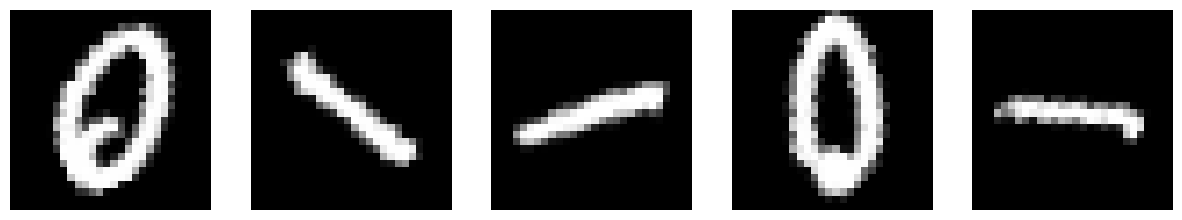

In [11]:
import torchvision.transforms as transforms

fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    imagen = raw_mnist_test[i][0]
    transform = transforms.ToTensor()
    tensor_imagen = transform(imagen)
    print(tensor_imagen.shape)
    axs[i].imshow(tensor_imagen.squeeze(), cmap='gray')
    axs[i].axis('off')

plt.show()

In [12]:
train_transform = Compose([
    pad,
    resize1,
    RandomRotation(180., interpolation=InterpolationMode.BILINEAR, expand=False),
    resize2,
    totensor,
])

mnist_train = MnistRotDataset(mode='train', transform=train_transform)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64)


test_transform = Compose([
    pad,
    totensor,
])
mnist_test = MnistRotDataset(mode='test', transform=test_transform)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)

In [13]:
from torch.utils.data import DataLoader, Subset
import numpy as np

dataset_size = len(mnist_train)
indices = list(range(dataset_size))
np.random.shuffle(indices)

subset_size = int(dataset_size * 0.2)
subset_indices = indices[:subset_size]

train_subset = Subset(mnist_train, subset_indices)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

In [14]:
import csv
import time

# Initialize variables to store metrics
training_time = 0
inference_time = 0
final_train_accuracy = 0
final_test_accuracy = 0

# Function to calculate accuracy
def calculate_accuracy(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, t in loader:
            x, t = x.to(device), t.to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            total += t.size(0)
            correct += (predicted == t).sum().item()
    return 100 * correct / total

# Start timing the training
start_time = time.time()

for epoch in range(10):
    model.train()
    for i, (x, t) in enumerate(train_loader):
        optimizer.zero_grad()
        x, t = x.to(device), t.to(device)
        y = model(x)
        loss = loss_function(y, t)
        loss.backward()
        optimizer.step()

    # Calculate accuracies
    train_accuracy = calculate_accuracy(model, train_loader, device)
    test_accuracy = calculate_accuracy(model, test_loader, device)

    print(f"Epoch {epoch+1}/10 | Train Acc: {train_accuracy:.2f}% | Test Acc: {test_accuracy:.2f}%")

    # Update final accuracies
    final_train_accuracy = train_accuracy
    final_test_accuracy = test_accuracy

# End timing the training
end_time = time.time()
training_time = end_time - start_time

# Measure inference time
inference_start_time = time.time()
model.eval()
with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)
        _ = model(x)
inference_end_time = time.time()
inference_time = inference_end_time - inference_start_time

# Prepare metrics for CSV
metrics = {
    'Optimizer': 'Adam',
    'Learning_Rate': 5e-5,
    'Weight_Decay': 1e-5,
    'Batch_Size': 64,
    'Epochs': 10,
    'Loss_Function': 'CrossEntropyLoss',
    'Training_Subset_Size': f"{subset_size} (10% of full dataset)",
    'Training_Time': f"{training_time:.2f}",
    'Inference_Time': f"{inference_time:.2f}",
    'Final_Train_Accuracy': f"{final_train_accuracy:.2f}",
    'Final_Test_Accuracy': f"{final_test_accuracy:.2f}"
}

# Write metrics to CSV
csv_filename = 'mnist_metrics.csv'
with open(csv_filename, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=metrics.keys())
    writer.writeheader()
    writer.writerow(metrics)

print(f"Metrics have been saved to {csv_filename}")

Epoch 1/10 | Train Acc: 88.67% | Test Acc: 91.36%
Epoch 2/10 | Train Acc: 97.85% | Test Acc: 98.31%
Epoch 3/10 | Train Acc: 99.80% | Test Acc: 99.32%
Epoch 4/10 | Train Acc: 100.00% | Test Acc: 99.67%
Epoch 5/10 | Train Acc: 99.80% | Test Acc: 99.72%
Epoch 6/10 | Train Acc: 99.80% | Test Acc: 99.72%
Epoch 7/10 | Train Acc: 100.00% | Test Acc: 99.74%
Epoch 8/10 | Train Acc: 100.00% | Test Acc: 99.81%
Epoch 9/10 | Train Acc: 100.00% | Test Acc: 99.84%
Epoch 10/10 | Train Acc: 100.00% | Test Acc: 99.86%
Metrics have been saved to mnist_metrics.csv


In [15]:

# retrieve the first image from the test set
x, y = next(iter(raw_mnist_test))


# evaluate the model
test_model(model, x)


##########################################################################################
angle |       0       1
    0 : [ 2.5124595 -2.3499515]
   45 : [ 2.6684754 -2.3709362]
   90 : [ 2.5123637 -2.3495543]
  135 : [ 2.668788  -2.3713925]
  180 : [ 2.5125954 -2.3497071]
  225 : [ 2.6687324 -2.3709848]
  270 : [ 2.5125558 -2.349673 ]
  315 : [ 2.668761 -2.371235]
##########################################################################################

